Name - Harsh Kasundra

Roll No. - U23AI125

In [170]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dataset_path = r"C:\Users\Asus\Desktop\semV\DS lab\PCA\archive"

img_h, img_w = 112, 92
X = []
y = []

# Load images and flatten
for subject in range(1, 41):
    subject_path = os.path.join(dataset_path, f"s{subject}")
    for img_name in os.listdir(subject_path):
        img_path = os.path.join(subject_path, img_name)
        img = Image.open(img_path).convert("L")
        img = img.resize((img_w, img_h))
        X.append(np.array(img).flatten())
        y.append(subject)

X = np.array(X)
y = np.array(y)

print("Original dataset:", X.shape)


Original dataset: (400, 10304)


In [171]:
#Standardizing the data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("After scaling:", X_scaled.shape)


After scaling: (400, 10304)


In [172]:
# Spliiting into train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y 
)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (320, 10304)
Testing set: (80, 10304)


In [173]:
# Calculate mean face 
mean_face = np.mean(X_train, axis=0)

# Mean-centering the data
X_train_centered = X_train - mean_face
X_test_centered  = X_test - mean_face


In [174]:
# Small matrix trick
# L = X_train_centered @ X_train_centered.T  -> shape (num_samples x num_samples)
L = X_train_centered @ X_train_centered.T
print(f"Shape of smaller covariance matrix L: {L.shape}")


Shape of smaller covariance matrix L: (320, 320)


In [175]:
# Eigenvalues and eigenvectors
eigenvalues, eigenvectors_small = np.linalg.eigh(L)

# Sort eigenvectors by descending eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors_small = eigenvectors_small[:, sorted_indices]


In [176]:
# Eigenfaces = X_train_centered.T @ eigenvectors_small
eigenfaces = X_train_centered.T @ sorted_eigenvectors_small

# Normalize each eigenface (unit length)
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

# Pick top k eigenfaces
k = 100
eigenfaces = eigenfaces[:, :k]
print(f"Shape of top {k} eigenfaces: {eigenfaces.shape}")


Shape of top 100 eigenfaces: (10304, 100)


In [177]:
# Project training and testing data
X_train_pca = X_train_centered @ eigenfaces  # (num_train_samples, k)
X_test_pca  = X_test_centered  @ eigenfaces  # (num_test_samples, k)

print("Projected training data shape:", X_train_pca.shape)
print("Projected testing data shape:", X_test_pca.shape)


Projected training data shape: (320, 100)
Projected testing data shape: (80, 100)


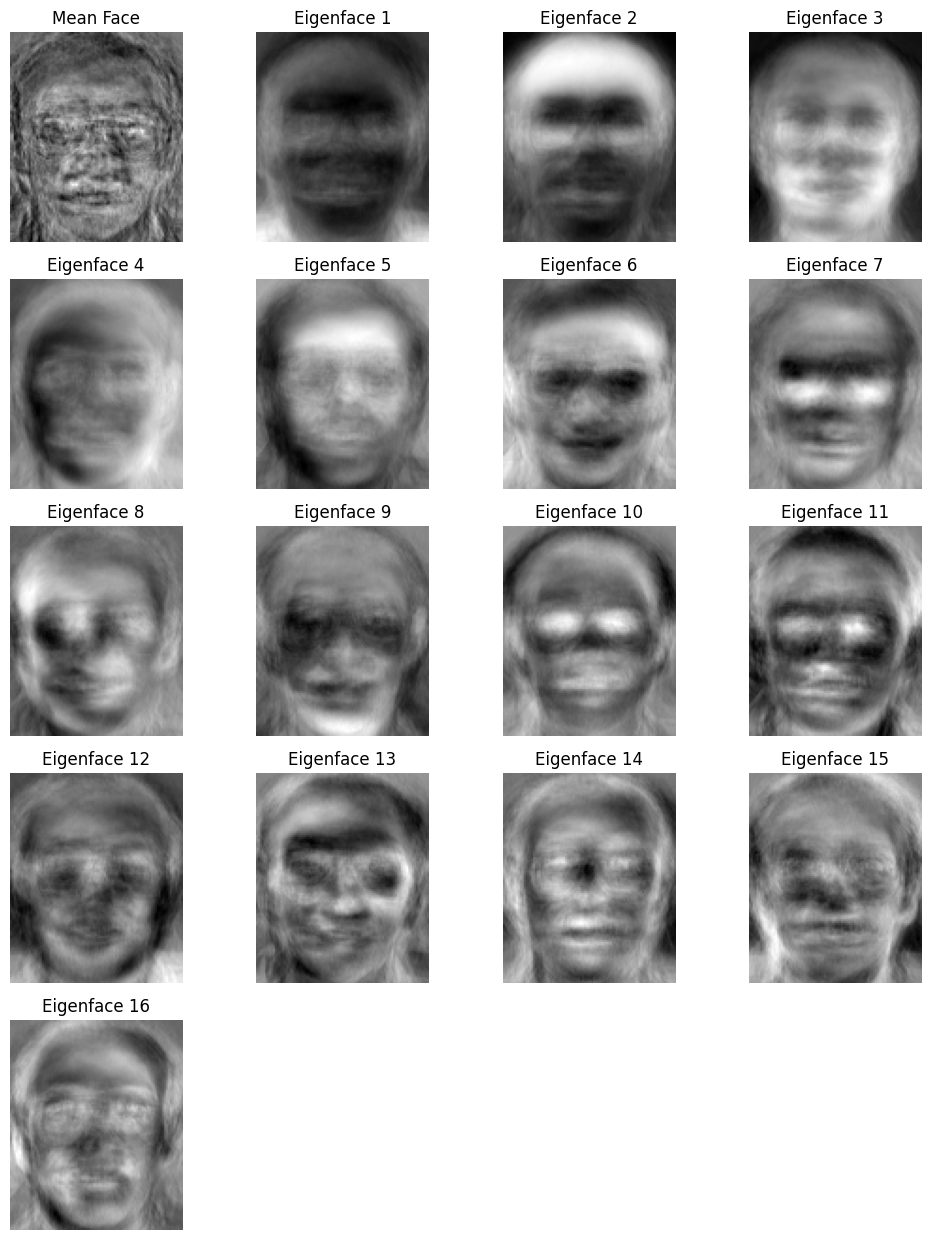

In [178]:
import matplotlib.pyplot as plt

# Normalize a face vector for display
def normalize_face(face):
    return (face - np.min(face)) / (np.max(face) - np.min(face))

# Plot mean face + eigenfaces
def plot_mean_and_eigenfaces(mean_face, eigenfaces, h=112, w=92, n_row=4, n_col=4):
    plt.figure(figsize=(2.5 * n_col, 2.5 * (n_row + 1)))  # extra row for mean face
    
    # mean face
    ax = plt.subplot(n_row + 1, n_col, 1)
    ax.imshow(normalize_face(mean_face).reshape((h, w)), cmap='gray')
    ax.set_title("Mean Face")
    ax.axis('off')
    
    for i in range(n_row * n_col):
        ax = plt.subplot(n_row + 1, n_col, i + 2)  # +2 because mean face occupies first
        face = normalize_face(eigenfaces[:, i])
        ax.imshow(face.reshape((h, w)), cmap='gray')
        ax.set_title(f"Eigenface {i+1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
plot_mean_and_eigenfaces(mean_face, eigenfaces, n_row=4, n_col=4)


In [179]:
def reconstruct_face(face_vector, mean_face, eigenfaces, k):
    """
    Reconstruct a face using top k eigenfaces
    """
    top_eigenfaces = eigenfaces[:, :k]           # use first k eigenfaces
    face_centered = face_vector - mean_face     # center the face
    weights = np.dot(face_centered, top_eigenfaces)  # project into PCA space
    reconstruction = mean_face + np.dot(weights, top_eigenfaces.T)  # reconstruct
    return reconstruction


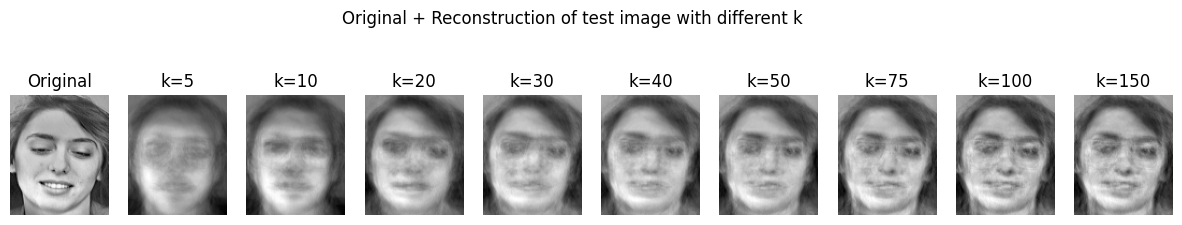

In [180]:
import matplotlib.pyplot as plt

# Pick a test image
test_face = X_test[0]

# Different k values
k_values = [5, 10, 20, 30, 40, 50, 75, 100, 150]

plt.figure(figsize=(15, 3))

# Original image 
ax = plt.subplot(1, len(k_values) + 1, 1)
plt.imshow(test_face.reshape(112, 92), cmap='gray')
plt.title("Original")
plt.axis('off')

# Reconstructed images 
for i, k in enumerate(k_values):
    reconstructed = reconstruct_face(test_face, mean_face, eigenfaces, k)
    ax = plt.subplot(1, len(k_values) + 1, i + 2)
    plt.imshow(reconstructed.reshape(112, 92), cmap='gray')
    plt.title(f"k={k}")
    plt.axis('off')

plt.suptitle("Original + Reconstruction of test image with different k")
plt.show()


In [181]:

def nearest_neighbor_classifier(X_train_pca, y_train, X_test_pca):
    
    y_pred = []
    for test_vec in X_test_pca:
        distances = np.linalg.norm(X_train_pca - test_vec, axis=1)
        nearest_idx = np.argmin(distances)
        y_pred.append(y_train[nearest_idx])
    return np.array(y_pred)


In [182]:
from sklearn.metrics import accuracy_score

k_values = [5 , 10, 20, 30, 40, 50, 75, 100, 150]
accuracies = []

for k in k_values:
    # Project train/test into top k eigenfaces
    X_train_k = X_train_centered @ eigenfaces[:, :k]
    X_test_k  = X_test_centered  @ eigenfaces[:, :k]
    
    # Predict labels using 1-NN
    y_pred = nearest_neighbor_classifier(X_train_k, y_train, X_test_k)
    
    # Compute accuracy
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"k={k}, Recognition Accuracy = {acc*100:.2f}%")


k=5, Recognition Accuracy = 91.25%
k=10, Recognition Accuracy = 96.25%
k=20, Recognition Accuracy = 98.75%
k=30, Recognition Accuracy = 98.75%
k=40, Recognition Accuracy = 98.75%
k=50, Recognition Accuracy = 98.75%
k=75, Recognition Accuracy = 98.75%
k=100, Recognition Accuracy = 98.75%
k=150, Recognition Accuracy = 98.75%


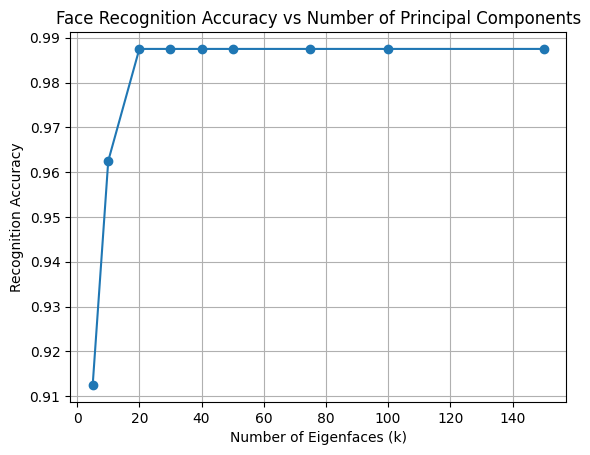

In [183]:
import matplotlib.pyplot as plt

plt.plot(k_values, accuracies, marker='o')
plt.xlabel("Number of Eigenfaces (k)")
plt.ylabel("Recognition Accuracy")
plt.title("Face Recognition Accuracy vs Number of Principal Components")
plt.grid(True)
plt.show()


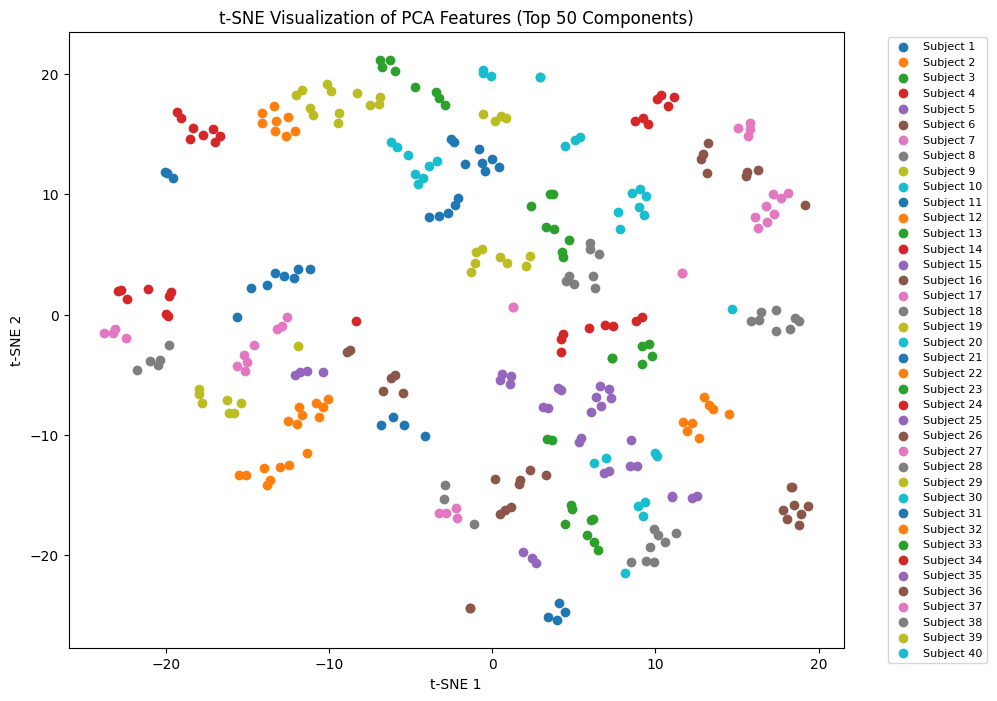

In [184]:
from sklearn.manifold import TSNE

# Use top 50 PCA features
k_tsne = 50
X_train_tsne = X_train_centered @ eigenfaces[:, :k_tsne]

# t-SNE reduction to 2D
tsne = TSNE(n_components=2, random_state=5)
X_embedded = tsne.fit_transform(X_train_tsne)

# Plot with different subjects in different colors
plt.figure(figsize=(10,8))
for label in np.unique(y_train):
    plt.scatter(
        X_embedded[y_train==label, 0],
        X_embedded[y_train==label, 1],
        label=f"Subject {label}"
    )
plt.title("t-SNE Visualization of PCA Features (Top 50 Components)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.show()
